In [1]:
# Importing Library 
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Importing data
alnz = pd.read_csv('data/allianz.csv')
depost = pd.read_csv('data/deutsche-post.csv')
detel = pd.read_csv('data/deutsche-telekom.csv')
merckg = pd.read_csv('data/merck-kgaa.csv')
siem = pd.read_csv('data/siemens.csv')

In [3]:
#Drop unnecessary data
alnz.drop(columns=['High','Low','Open','Volume', 'Dividends', 'Stock Splits', 'Ticker', 'ps-ratio'],inplace=True)
depost.drop(columns=['High','Low','Open','Volume', 'Dividends', 'Stock Splits', 'Ticker', 'ps-ratio'],inplace=True)
detel.drop(columns=['High','Low','Open','Volume', 'Dividends', 'Stock Splits', 'Ticker', 'ps-ratio'],inplace=True)
merckg.drop(columns=['High','Low','Open','Volume', 'Dividends', 'Stock Splits', 'Ticker', 'ps-ratio'],inplace=True)
siem.drop(columns=['High','Low','Open','Volume', 'Dividends', 'Stock Splits', 'Ticker', 'ps-ratio'],inplace=True)

In [4]:
# Change Dtype of Date column
alnz['Date']=pd.to_datetime(alnz['Date'])
depost['Date']=pd.to_datetime(depost['Date'])
detel['Date']=pd.to_datetime(detel['Date'])
merckg['Date']=pd.to_datetime(merckg['Date'])
siem['Date']=pd.to_datetime(siem['Date'])

In [5]:
#Set Index as Date
alnz.set_index('Date',inplace=True)
depost.set_index('Date',inplace=True)
detel.set_index('Date',inplace=True)
merckg.set_index('Date',inplace=True)
siem.set_index('Date',inplace=True)

In [6]:
# Backup data
siem_base = siem.copy()
detel_base = detel.copy()
alnz_base = alnz.copy()
merckg_base = merckg.copy()
depost_base = depost.copy()

# Allianz 3 Features

In [7]:
#Set next day value as target 
alnz['Target'] = alnz.Close.shift(-1)
alnz.dropna(inplace=True)
alnz

,Close,pe-ratio,pb-ratio,Target
Date,,,,
2010-01-04,45.519119,9.154412,1.292624,45.657921
2010-01-05,45.657921,9.154412,1.292624,46.012665
2010-01-06,46.012665,9.154412,1.292624,45.483131
2010-01-07,45.483131,9.154412,1.292624,45.236355
2010-01-08,45.236355,9.154412,1.292624,44.727394
...,...,...,...,...
2023-06-23,209.149994,10.264393,1.461468,209.199997
2023-06-26,209.199997,10.264393,1.461468,211.300003
2023-06-27,211.300003,10.264393,1.461468,211.649994


In [8]:
# Set date variable
start_date = '2010-01-04' # Start date of training set
end_date = '2020-10-07' # End date of training set
test_start_date = '2020-10-08' # End date of test set
test_end_date = '2023-06-30' # End date of test set

In [9]:
#split train and test data
alnz_train = alnz.loc[:end_date]
alnz_test = alnz.loc[test_start_date:]

In [10]:
# Reconcile length of data set and subsets
alnz.shape[0] == alnz_train.shape[0] + alnz_test.shape[0]

True

In [11]:
#set features and target
alnz_X_train = alnz_train[['Close', 'pe-ratio', 'pb-ratio']]
alnz_y_train = alnz_train['Target']
alnz_X_test = alnz_test[['Close', 'pe-ratio', 'pb-ratio']]
alnz_y_test = alnz_test['Target']

# Model

In [12]:
parameters = {
    'kernel': ['linear', 'rbf'],          
    'C': [0.1, 1, 10],   # Reduced the range                
    'gamma': ['scale'],  # Removed 'auto'
    'epsilon': [0.1, 0.2],  # Reduced the values                       
}

In [13]:
# Initialize GridSearchCV with optimized parameters
model1 = SVR()
grid_search1 = GridSearchCV(estimator=model1, 
                            param_grid=parameters, 
                            cv=3, 
                            scoring='neg_mean_squared_error', 
                            verbose=False, 
                            n_jobs=-1)
grid_search1.fit(alnz_X_train, alnz_y_train)
print(f'Best params: {grid_search1.best_params_}')
print(f'Best validation score = {grid_search1.best_score_}')

Best params: {'C': 0.1, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'linear'}
Best validation score = -2.41835427297522


In [14]:
#fit the model
model1 = SVR(**grid_search1.best_params_)
model1.fit(alnz_X_train, alnz_y_train)

SVR(C=0.1, epsilon=0.2, kernel='linear')

In [15]:
#predicted data 
alnz_test['Predicted_Close'] = model1.predict(alnz_X_test)

In [16]:
#show the result
alnz_test

,Close,pe-ratio,pb-ratio,Target,Predicted_Close
Date,,,,,
2020-10-08,144.441971,9.953418,0.874770,144.838226,144.539335
2020-10-09,144.838226,9.953418,0.874770,146.302643,144.935693
2020-10-12,146.302643,9.953418,0.874770,143.442734,146.400487
2020-10-13,143.442734,9.953418,0.874770,143.873459,143.539841
2020-10-14,143.873459,9.953418,0.874770,139.755890,143.970677
...,...,...,...,...,...
2023-06-23,209.149994,10.264393,1.461468,209.199997,209.219644
2023-06-26,209.199997,10.264393,1.461468,211.300003,209.269660
2023-06-27,211.300003,10.264393,1.461468,211.649994,211.370207


In [17]:
# Create a dataframe that has same index as allianz dataframe
result1 = pd.DataFrame(index=alnz_base.index)
# Extract actual data from SIE
tem1 = alnz_base['Close'].tolist()[:len(alnz_base)-695]
# Extract forecasted date from above result
tem2 = alnz_test['Predicted_Close'].tolist()
# Combine them to a list
tem3 = tem1 + tem2
# Create a column from the resulted list
result1['ALV'] = tem3
# Mark forecasted or not for each line
result1['Forecasted'] = 'N'
result1.loc[result1.index[-695:], 'Forecasted'] = 'Y'

In [18]:
#added predicted data with real data
result1

,ALV,Forecasted
Date,,
2010-01-04,45.519119,N
2010-01-05,45.657921,N
2010-01-06,46.012665,N
2010-01-07,45.483131,N
2010-01-08,45.236355,N
...,...,...
2023-06-26,209.219644,Y
2023-06-27,209.269660,Y
2023-06-28,211.370207,Y


In [19]:
#again return to previous shape
alnz_y_test = np.array(alnz_test['Target'])

In [20]:
#checking mse and rmse 
alnz_mse = mean_squared_error(alnz_y_test, alnz_test['Predicted_Close'])
alnz_rmse = math.sqrt(alnz_mse)
alnz_mape = np.mean(np.abs(alnz_test['Predicted_Close'] - alnz_y_test)/np.abs(alnz_y_test))

print(f'Root Mean Squared Error (RMSE): {alnz_rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {alnz_mape}')

Root Mean Squared Error (RMSE): 2.559697958601435
Mean Absolute Percentage Error (MAPE): 0.009499395185964443


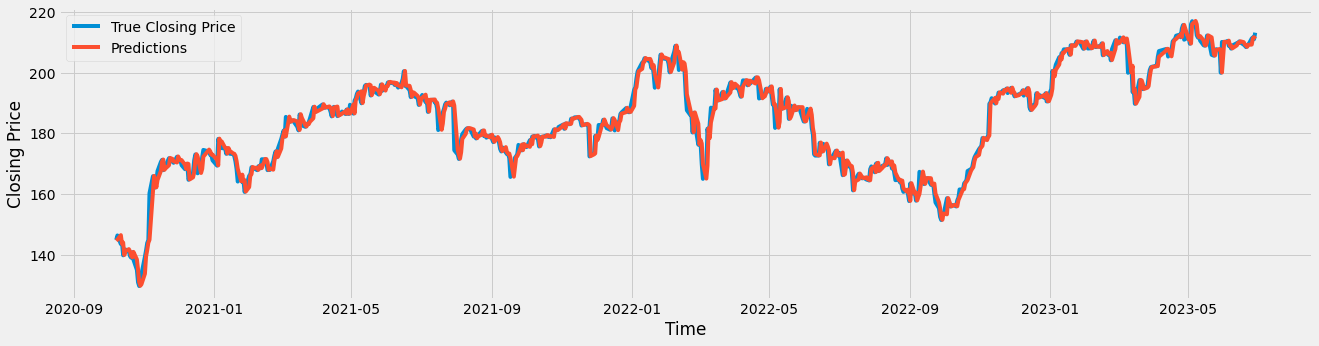

In [21]:
#shwing predicted data
plt.figure(figsize=(20, 5))
plt.plot(alnz_test['Target'], label = 'True Closing Price')
plt.plot(alnz_test['Predicted_Close'], label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(labels = ['True Closing Price', 'Predictions'])

# Deutsche Post 3 Features

In [22]:
#Set next day value as target 
depost['Target'] = depost.Close.shift(-1)
depost.dropna(inplace=True)
depost

,Close,pe-ratio,pb-ratio,Target
Date,,,,
2010-01-04,13.980000,25.443396,1.970697,14.000
2010-01-05,14.000000,25.443396,1.970697,14.155
2010-01-06,14.155000,25.443396,1.970697,14.125
2010-01-07,14.125000,25.443396,1.970697,14.460
2010-01-08,14.460000,25.443396,1.970697,14.380
...,...,...,...,...
2023-06-23,43.189999,10.613300,1.588590,43.000
2023-06-26,43.000000,10.613300,1.588590,43.500
2023-06-27,43.500000,10.613300,1.588590,44.305


In [23]:
#split train and test data
depost_train = depost.loc[:end_date]
depost_test = depost.loc[test_start_date:]

In [24]:
# Reconcile length of data set and subsets
depost.shape[0] == depost_train.shape[0] + depost_test.shape[0]

True

In [25]:
#set features and target
depost_X_train = depost_train[['Close', 'pe-ratio', 'pb-ratio']]
depost_y_train = depost_train['Target']
depost_X_test = depost_test[['Close', 'pe-ratio', 'pb-ratio']]
depost_y_test = depost_test['Target']

In [26]:
# Initialize GridSearchCV with optimized parameters
model2 = SVR()
grid_search2 = GridSearchCV(estimator=model2, 
                            param_grid=parameters, 
                            cv=3, 
                            scoring='neg_mean_squared_error', 
                            verbose=False, 
                            n_jobs=-1)
grid_search2.fit(depost_X_train, depost_y_train)
print(f'Best params: {grid_search2.best_params_}')
print(f'Best validation score = {grid_search2.best_score_}')

Best params: {'C': 10, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best validation score = -0.1420318782208213


In [27]:
#fit the model
model2 = SVR(**grid_search2.best_params_)
model2.fit(depost_X_train, depost_y_train)

SVR(C=10, kernel='linear')

In [28]:
#predicted data 
depost_test['Predicted_Close'] = model2.predict(depost_X_test)

In [29]:
#agin return to previous shape
depost_y_test = np.array(depost_test['Target'])

In [30]:
#checking mse and rmse 
depost_mse = mean_squared_error(depost_y_test, depost_test['Predicted_Close'])
depost_rmse = math.sqrt(depost_mse)
depost_mape = np.mean(np.abs(depost_test['Predicted_Close'] - depost_y_test)/np.abs(depost_y_test))

print(f'Root Mean Squared Error (RMSE): {depost_rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {depost_mape}')

Root Mean Squared Error (RMSE): 0.7751737690861198
Mean Absolute Percentage Error (MAPE): 0.013195785796463636


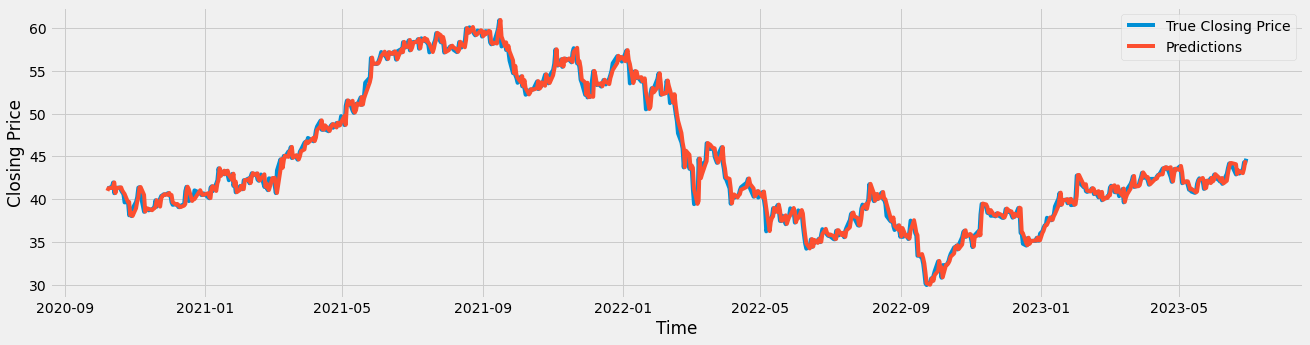

In [31]:
#shwing predicted data
plt.figure(figsize=(20, 5))
plt.plot(depost_test['Target'], label = 'True Closing Price')
plt.plot(depost_test['Predicted_Close'], label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(labels = ['True Closing Price', 'Predictions'])

In [32]:
#checking predicted data
depost_test

,Close,pe-ratio,pb-ratio,Target,Predicted_Close
Date,,,,,
2020-10-08,40.970001,18.933283,3.600308,41.279999,40.986504
2020-10-09,41.279999,18.933283,3.600308,41.299999,41.296801
2020-10-12,41.299999,18.933283,3.600308,41.470001,41.316821
2020-10-13,41.470001,18.933283,3.600308,41.950001,41.486987
2020-10-14,41.950001,18.933283,3.600308,40.709999,41.967449
...,...,...,...,...,...
2023-06-23,43.189999,10.613300,1.588590,43.000000,43.237494
2023-06-26,43.000000,10.613300,1.588590,43.500000,43.047312
2023-06-27,43.500000,10.613300,1.588590,44.305000,43.547794


In [33]:
# Extract actual data from depost
tem1 = depost_base['Close'].tolist()[:len(depost_base)+6-695]
# Extract forecasted date from above result
tem2 = depost_test['Predicted_Close'].tolist()
# Combine them to a list
tem3 = tem1 + tem2
# Create a column from the resulted list
result1['DHL'] = tem3

In [34]:
#added predicted data with real data
result1

,ALV,Forecasted,DHL
Date,,,
2010-01-04,45.519119,N,13.980000
2010-01-05,45.657921,N,14.000000
2010-01-06,46.012665,N,14.155000
2010-01-07,45.483131,N,14.125000
2010-01-08,45.236355,N,14.460000
...,...,...,...
2023-06-26,209.219644,Y,43.237494
2023-06-27,209.269660,Y,43.047312
2023-06-28,211.370207,Y,43.547794


# Deutsche Telekom 3 Features

In [35]:
#Set next day value as target 
detel['Target'] = detel.Close.shift(-1)
detel.dropna(inplace=True)
detel

,Close,pe-ratio,pb-ratio,Target
Date,,,,
2010-01-04,4.953136,128.625000,1.070129,4.911083
2010-01-05,4.911083,128.625000,1.070129,4.789590
2010-01-06,4.789590,128.625000,1.070129,4.698472
2010-01-07,4.698472,128.625000,1.070129,4.724171
2010-01-08,4.724171,128.625000,1.070129,4.756881
...,...,...,...,...
2023-06-23,19.558001,5.658228,1.057418,19.695999
2023-06-26,19.695999,5.658228,1.057418,19.906000
2023-06-27,19.906000,5.658228,1.057418,20.030001


In [36]:
#split train and test data
detel_train = detel.loc[:end_date]
detel_test = detel.loc[test_start_date:]

In [37]:
# Reconcile length of data set and subsets
detel.shape[0] == detel_train.shape[0] + detel_test.shape[0]

True

In [38]:
#set features and target
detel_X_train = detel_train[['Close', 'pe-ratio', 'pb-ratio']]
detel_y_train = detel_train['Target']
detel_X_test = detel_test[['Close', 'pe-ratio', 'pb-ratio']]
detel_y_test = detel_test['Target']

In [39]:
#fit the model
model3 = SVR(**grid_search1.best_params_)
model3.fit(detel_X_train, detel_y_train)

SVR(C=0.1, epsilon=0.2, kernel='linear')

In [40]:
#predicted data 
detel_test['Predicted_Close'] = model3.predict(detel_X_test)

In [41]:
#showing predicted data
detel_test

,Close,pe-ratio,pb-ratio,Target,Predicted_Close
Date,,,,,
2020-10-08,13.030954,21.651515,0.940896,12.981357,13.025753
2020-10-09,12.981357,21.651515,0.940896,13.067026,12.976392
2020-10-12,13.067026,21.651515,0.940896,13.107607,13.061653
2020-10-13,13.107607,21.651515,0.940896,13.053500,13.102039
2020-10-14,13.053500,21.651515,0.940896,12.643183,13.048191
...,...,...,...,...,...
2023-06-23,19.558001,5.658228,1.057418,19.695999,19.521007
2023-06-26,19.695999,5.658228,1.057418,19.906000,19.658347
2023-06-27,19.906000,5.658228,1.057418,20.030001,19.867344


In [42]:
#agin return to previous shape
detel_y_test = np.array(detel_test['Target'])

In [43]:
#checking mse and rmse 
detel_mse = mean_squared_error(detel_y_test, detel_test['Predicted_Close'])
detel_rmse = math.sqrt(detel_mse)
detel_mape = np.mean(np.abs(detel_test['Predicted_Close'] - detel_y_test)/np.abs(detel_y_test))

print(f'Root Mean Squared Error (RMSE): {detel_rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {detel_mape}')

Root Mean Squared Error (RMSE): 0.20970922801987735
Mean Absolute Percentage Error (MAPE): 0.009098832255466094


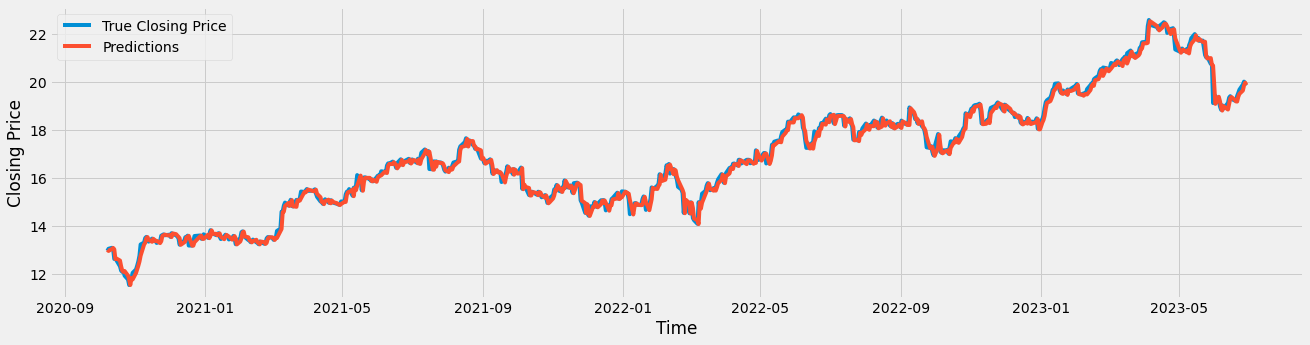

In [44]:
#shwing predicted data
plt.figure(figsize=(20, 5))
plt.plot(detel_test['Target'], label = 'True Closing Price')
plt.plot(detel_test['Predicted_Close'], label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(labels = ['True Closing Price', 'Predictions'])

In [45]:
# Extract actual data from deutsche-telekom
tem1 = detel_base['Close'].tolist()[:len(detel_base)-695]
# Extract forecasted date from above result
tem2 = detel_test['Predicted_Close'].tolist()
# Combine them to a list
tem3 = tem1 + tem2
# Create a column from the resulted list
result1['DTE'] = tem3

In [46]:
#added predicted data with real data
result1

,ALV,Forecasted,DHL,DTE
Date,,,,
2010-01-04,45.519119,N,13.980000,4.953136
2010-01-05,45.657921,N,14.000000,4.911083
2010-01-06,46.012665,N,14.155000,4.789590
2010-01-07,45.483131,N,14.125000,4.698472
2010-01-08,45.236355,N,14.460000,4.724171
...,...,...,...,...
2023-06-26,209.219644,Y,43.237494,19.521007
2023-06-27,209.269660,Y,43.047312,19.658347
2023-06-28,211.370207,Y,43.547794,19.867344


# Merck KGaA 2 Features

In [47]:
#Set next day value as target 
merckg['Target'] = merckg.Close.shift(-1)
merckg.dropna(inplace=True)
merckg

,Close,pe-ratio,pb-ratio,Target
Date,,,,
2010-01-04,26.576839,38.785717,1.488928,26.381214
2010-01-05,26.381214,38.785717,1.488928,26.364910
2010-01-06,26.364910,38.785717,1.488928,26.919188
2010-01-07,26.919188,38.785717,1.488928,26.646120
2010-01-08,26.646120,38.785717,1.488928,26.739857
...,...,...,...,...
2023-06-23,152.949997,23.026846,3.013593,152.600006
2023-06-26,152.600006,23.026846,3.013593,147.199997
2023-06-27,147.199997,23.026846,3.013593,150.500000


In [48]:
#split train and test data
merckg_train = merckg.loc[:end_date]
merckg_test = merckg.loc[test_start_date:]

In [49]:
# Reconcile length of data set and subsets
merckg.shape[0] == merckg_train.shape[0] + merckg_test.shape[0]

True

In [50]:
#set features and target
merckg_X_train = merckg_train[['Close', 'pe-ratio', 'pb-ratio']]
merckg_y_train = merckg_train['Target']
merckg_X_test = merckg_test[['Close', 'pe-ratio', 'pb-ratio']]
merckg_y_test = merckg_test['Target']

In [51]:
#fit the model
model4 = SVR(**grid_search1.best_params_)
model4.fit(merckg_X_train, merckg_y_train)

SVR(C=0.1, epsilon=0.2, kernel='linear')

In [52]:
#predicted data 
merckg_test['Predicted_Close'] = model4.predict(merckg_X_test)

In [53]:
merckg_test

,Close,pe-ratio,pb-ratio,Target,Predicted_Close
Date,,,,,
2020-10-08,126.032745,28.965117,3.009257,126.661209,126.098138
2020-10-09,126.661209,28.965117,3.009257,126.661209,126.727369
2020-10-12,126.661209,28.965117,3.009257,126.226120,126.727369
2020-10-13,126.226120,28.965117,3.009257,124.098984,126.291749
2020-10-14,124.098984,28.965117,3.009257,119.699684,124.162015
...,...,...,...,...,...
2023-06-23,152.949997,23.026846,3.013593,152.600006,153.059016
2023-06-26,152.600006,23.026846,3.013593,147.199997,152.708598
2023-06-27,147.199997,23.026846,3.013593,150.500000,147.301996


In [54]:
#agin return to previous shape
merckg_y_test = np.array(merckg_test['Target'])

In [55]:
#checking mse and rmse 
merckg_mse = mean_squared_error(merckg_y_test, merckg_test['Predicted_Close'])
merckg_rmse = math.sqrt(merckg_mse)
merckg_mape = np.mean(np.abs(merckg_test['Predicted_Close'] - merckg_y_test)/np.abs(merckg_y_test))

print(f'Root Mean Squared Error (RMSE): {merckg_rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {merckg_mape}')

Root Mean Squared Error (RMSE): 3.001371307098782
Mean Absolute Percentage Error (MAPE): 0.012855481626219268


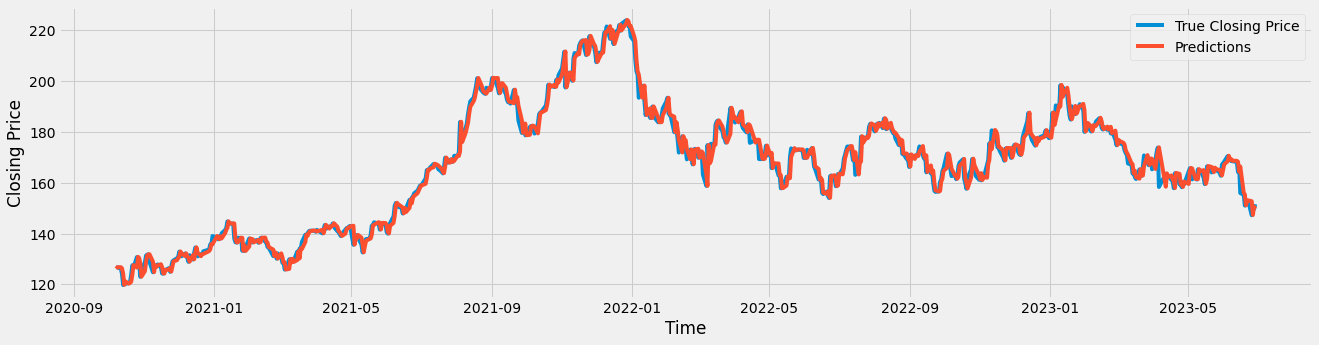

In [56]:
#plotting predicted data
plt.figure(figsize=(20, 5))
plt.plot(merckg_test['Target'], label = 'True Closing Price')
plt.plot(merckg_test['Predicted_Close'], label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(labels = ['True Closing Price', 'Predictions'])

In [57]:
# Extract actual data from merck-kgaa
tem1 = merckg_base['Close'].tolist()[:len(merckg_base)-695]
# Extract forecasted date from above result
tem2 = merckg_test['Predicted_Close'].tolist()
# Combine them to a list
tem3 = tem1 + tem2
# Create a column from the resulted list
result1['MRK'] = tem3

In [58]:
#added predicted data with real data
result1

,ALV,Forecasted,DHL,DTE,MRK
Date,,,,,
2010-01-04,45.519119,N,13.980000,4.953136,26.576839
2010-01-05,45.657921,N,14.000000,4.911083,26.381214
2010-01-06,46.012665,N,14.155000,4.789590,26.364910
2010-01-07,45.483131,N,14.125000,4.698472,26.919188
2010-01-08,45.236355,N,14.460000,4.724171,26.646120
...,...,...,...,...,...
2023-06-26,209.219644,Y,43.237494,19.521007,153.059016
2023-06-27,209.269660,Y,43.047312,19.658347,152.708598
2023-06-28,211.370207,Y,43.547794,19.867344,147.301996


# Siemens 2 Features

In [59]:
#Set next day value as target 
siem['Target'] = siem.Close.shift(-1)
siem.dropna(inplace=True)
siem

,Close,pe-ratio,pb-ratio,Target
Date,,,,
2010-01-04,39.892437,21.092000,1.938798,39.916805
2010-01-05,39.916805,21.092000,1.938798,40.063042
2010-01-06,40.063042,21.092000,1.938798,40.538315
2010-01-07,40.538315,21.092000,1.938798,40.794235
2010-01-08,40.794235,21.092000,1.938798,40.897816
...,...,...,...,...
2023-06-23,156.979996,19.691292,1.998793,155.479996
2023-06-26,155.479996,19.691292,1.998793,157.559998
2023-06-27,157.559998,19.691292,1.998793,152.720001


In [60]:
#split train and test data
siem_train = siem.loc[:end_date]
siem_test = siem.loc[test_start_date:]

In [61]:
# Reconcile length of data set and subsets
siem.shape[0] == siem_train.shape[0] + siem_test.shape[0]

True

In [62]:
#set features and target
siem_X_train = siem_train[['Close', 'pe-ratio', 'pb-ratio']]
siem_y_train = siem_train['Target']
siem_X_test = siem_test[['Close', 'pe-ratio', 'pb-ratio']]
siem_y_test = siem_test['Target']

In [63]:
#fit the model
model5 = SVR(**grid_search1.best_params_)
model5.fit(siem_X_train, siem_y_train)

SVR(C=0.1, epsilon=0.2, kernel='linear')

In [64]:
#predicted data 
siem_test['Predicted_Close'] = model5.predict(siem_X_test)

In [65]:
#checking predicted data
siem_test

,Close,pe-ratio,pb-ratio,Target,Predicted_Close
Date,,,,,
2020-10-08,102.015335,21.575999,2.165320,102.678017,102.016149
2020-10-09,102.678017,21.575999,2.165320,103.487961,102.677818
2020-10-12,103.487961,21.575999,2.165320,102.383484,103.486525
2020-10-13,102.383484,21.575999,2.165320,103.451141,102.383735
2020-10-14,103.451141,21.575999,2.165320,100.634758,103.449762
...,...,...,...,...,...
2023-06-23,156.979996,19.691292,1.998793,155.479996,156.909488
2023-06-26,155.479996,19.691292,1.998793,157.559998,155.411779
2023-06-27,157.559998,19.691292,1.998793,152.720001,157.488603


In [66]:
#agin return to previous shape
siem_y_test = np.array(siem_test['Target'])

In [67]:
#added predicted data with real data
siem_mse = mean_squared_error(siem_y_test, siem_test['Predicted_Close'])
siem_rmse = math.sqrt(siem_mse)
siem_mape = np.mean(np.abs(siem_test['Predicted_Close'] - siem_y_test)/np.abs(siem_y_test))

print(f'Root Mean Squared Error (RMSE): {siem_rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {siem_mape}')

Root Mean Squared Error (RMSE): 2.358022678883611
Mean Absolute Percentage Error (MAPE): 0.014092373685564225


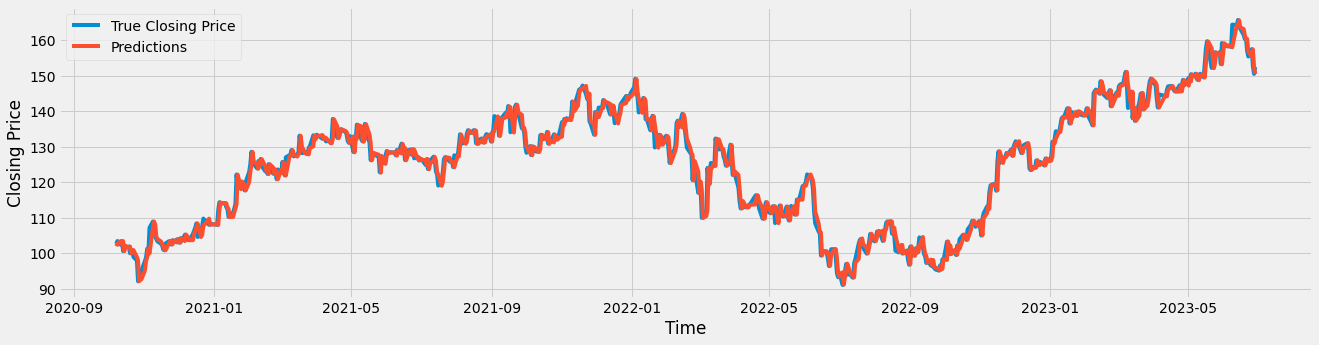

In [68]:
#plotting predicted data
plt.figure(figsize=(20, 5))
plt.plot(siem_test['Target'], label = 'True Closing Price')
plt.plot(siem_test['Predicted_Close'], label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(labels = ['True Closing Price', 'Predictions'])

In [69]:
# Extract actual data from siem
tem1 = siem_base['Close'].tolist()[:len(siem_base)-695]
# Extract forecasted date from above result
tem2 = siem_test['Predicted_Close'].tolist()
# Combine them to a list
tem3 = tem1 + tem2
# Create a column from the resulted list
result1['SIE'] = tem3

In [70]:
#merged all predicted data
result1

,ALV,Forecasted,DHL,DTE,MRK,SIE
Date,,,,,,
2010-01-04,45.519119,N,13.980000,4.953136,26.576839,39.892437
2010-01-05,45.657921,N,14.000000,4.911083,26.381214,39.916805
2010-01-06,46.012665,N,14.155000,4.789590,26.364910,40.063042
2010-01-07,45.483131,N,14.125000,4.698472,26.919188,40.538315
2010-01-08,45.236355,N,14.460000,4.724171,26.646120,40.794235
...,...,...,...,...,...,...
2023-06-26,209.219644,Y,43.237494,19.521007,153.059016,156.909488
2023-06-27,209.269660,Y,43.047312,19.658347,152.708598,155.411779
2023-06-28,211.370207,Y,43.547794,19.867344,147.301996,157.488603


In [71]:
# Define the desired column order
desired_order = ['SIE', 'DTE', 'ALV', 'MRK', 'DHL', 'Forecasted']

# Rearrange columns
result = result1[desired_order]
result

,SIE,DTE,ALV,MRK,DHL,Forecasted
Date,,,,,,
2010-01-04,39.892437,4.953136,45.519119,26.576839,13.980000,N
2010-01-05,39.916805,4.911083,45.657921,26.381214,14.000000,N
2010-01-06,40.063042,4.789590,46.012665,26.364910,14.155000,N
2010-01-07,40.538315,4.698472,45.483131,26.919188,14.125000,N
2010-01-08,40.794235,4.724171,45.236355,26.646120,14.460000,N
...,...,...,...,...,...,...
2023-06-26,156.909488,19.521007,209.219644,153.059016,43.237494,Y
2023-06-27,155.411779,19.658347,209.269660,152.708598,43.047312,Y
2023-06-28,157.488603,19.867344,211.370207,147.301996,43.547794,Y


In [72]:
#checking the final data
result

,SIE,DTE,ALV,MRK,DHL,Forecasted
Date,,,,,,
2010-01-04,39.892437,4.953136,45.519119,26.576839,13.980000,N
2010-01-05,39.916805,4.911083,45.657921,26.381214,14.000000,N
2010-01-06,40.063042,4.789590,46.012665,26.364910,14.155000,N
2010-01-07,40.538315,4.698472,45.483131,26.919188,14.125000,N
2010-01-08,40.794235,4.724171,45.236355,26.646120,14.460000,N
...,...,...,...,...,...,...
2023-06-26,156.909488,19.521007,209.219644,153.059016,43.237494,Y
2023-06-27,155.411779,19.658347,209.269660,152.708598,43.047312,Y
2023-06-28,157.488603,19.867344,211.370207,147.301996,43.547794,Y


In [73]:
#save forecased data in csv file
result.to_csv('SVMRegressor_3 feature.csv', index=True)

# Bibliography

-	Ozmen, A.K. (2018). _SVM-Stock-Prediction/ISBANK_SVM.ipynb at master · anyaozm/SVM-Stock-Prediction._ [online] GitHub. Available at: https://github.com/anyaozm/SVM-Stock-Prediction/blob/master/ISBANK_SVM.ipynb [Accessed 26 Feb. 2024].
-	pratyusha0608 (2019). _pratyusha0608/stock-prediction-using-svm-and-linear-regression-in-python._ [online] GitHub. Available at: https://github.com/pratyusha0608/stock-prediction-using-svm-and-linear-regression-in-python [Accessed 26 Feb. 2024].
-	Gao, R. (2023). _Stock-Price-Prediction-Using-Support-Vector-Regression-SVR-in-Python/predict_prices.py at main · ryangao0313/Stock-Price-Prediction-Using-Support-Vector-Regression-SVR-in-Python._ [online] GitHub. Available at: https://github.com/ryangao0313/Stock-Price-Prediction-Using-Support-Vector-Regression-SVR-in-Python/blob/main/predict_prices.py [Accessed 26 Feb. 2024].